In [13]:
from __future__ import division

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy import units as u

import ligo.skymap.plot
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter

import numpy as np
import healpy as hp

import scipy
import scipy.constants as sc
import scipy.integrate as si

import gworf
from gworf import gworf

Msol = 1.98855*10.0**30.0
yr = 365.25*86400.
omegaM = 0.3
omegaLam = 0.7
H0 = 70.0

## Let's import some GW sky-maps

In [14]:
sky_type = 'realpop'

In [15]:
sky = np.load('./maps/{}.npy'.format(sky_type))

In [16]:
## rank SMBBH population sources from loudest in GWs to weakest
idxs = np.argsort(sky)[::-1]

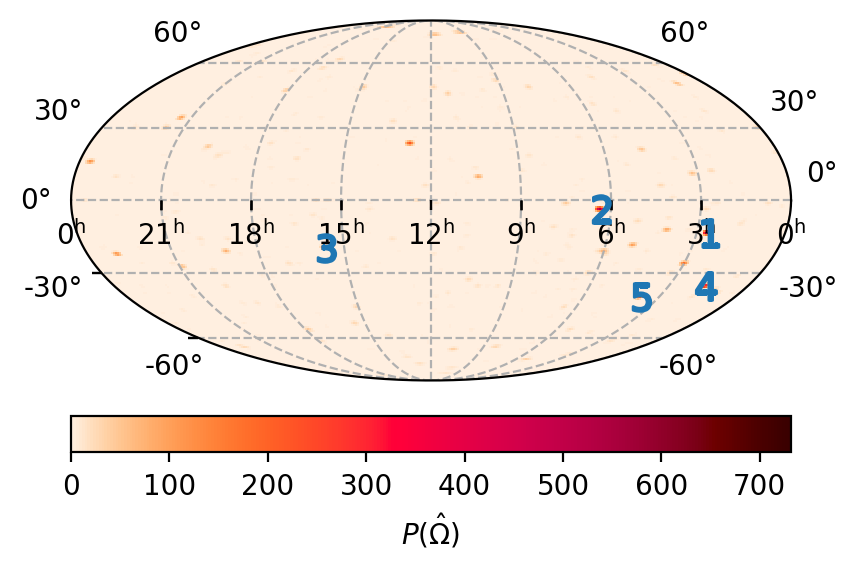

In [17]:
fig = plt.figure(figsize=(4, 4), dpi=100)

ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro hours mollweide')

ax.grid(linestyle='dashed')

cax = ax.imshow_hpx(sky, cmap='cylon',)#smooth=1.0*u.deg)
plt.colorbar(cax, orientation='horizontal',pad=0.05, label='$P(\hat\Omega)$')

for ii in range(5):
    dummy_coords = np.array(hp.pix2ang(nside=32, ipix=idxs[ii], lonlat=True))
    ax.plot(dummy_coords[0], dummy_coords[1],
                transform=ax.get_transform('world'),
                marker='${}$'.format(ii+1),
                markersize=10,
                markeredgewidth=1,
               color='C0')
plt.show()

## Compute the overlap reduction function coefficients for an array of pulsars

In [18]:
#############################################
# Set up array and prepare response matrices
#############################################

npsrs = 100

psr_theta = np.arccos(np.random.uniform(-1,1,npsrs)) # uniform in costheta
psr_phi = np.random.uniform(0, 2*np.pi, npsrs) # uniform in phi
psr_dists = np.random.normal(1.0, 0.2, npsrs) * 1000 # normal around 1kpc

ptapsrs = []
for ii in range(npsrs):
    ptapsrs.append(gworf.psr(raj=psr_phi[ii], 
                             decj=np.pi/2-psr_theta[ii], 
                             pdist=psr_dists[ii]))

In [7]:
#############################################
# Create the pixel signal response matrices
#############################################
nside = 32 # pixelation
npix = hp.nside2npix(nside)    # number of pixels total
freq = 2.5e-9 # assume a GW frequency (only needed for pulsar-term response)

#############################################
# First is theta, second is phi
#############################################
pixels = hp.pix2ang(nside, np.arange(npix), nest=False)
npixels = len(pixels[0])

F_e = afncs.signalResponse_earth(ptapsrs, pixels[0][:],
                                 pixels[1][:], dirconv=False)
F_p = afncs.signalResponse_pulsar(ptapsrs, pixels[0][:],
                                  pixels[1][:], freq=freq, dirconv=False)
F_tot = F_e + F_p

###############

psrpos_phi = np.array([ptapsrs[ii].raj
                       for ii in range(len(ptapsrs))],
                       dtype=np.float64)
psrpos_theta = np.array([np.pi/2.0 - ptapsrs[ii].decj
                         for ii in range(len(ptapsrs))],
                         dtype=np.float64)
psr_locs = np.array([psrpos_phi, psrpos_theta]).T

ModuleNotFoundError: No module named 'anisotropyfuncs'

In [50]:
sky_iso = np.ones(hp.nside2npix(32))
#sky_hotspot = sky
sky_realpop = sky

In [51]:
orf_iso = orf_offdiag(sky_iso, F_e)
#orf_hotspot = orf_offdiag(sky_hotspot, F_e)
orf_realpop = orf_offdiag(sky_realpop, F_e)